In [2]:
import numpy as np
import scipy.ndimage
from scipy.signal import argrelextrema
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# FROM SUITER https://bay-astronomers.org/TM/focusing.htm
# Zernike circle polynomials in same order as used in ZEMAX
# # limited to low order trefoil except no distortion, no piston,
# # and coefficients between trefoil and zonal spherical aberration
# # are neglected.
# ph =Coeff(1)*sqrt(3)*(2*rho^2-1);
# # defocus
# ph = ph + Coeff(2)*sqrt(6)*rho^2*cos(2*theta);
# # astig
# ph = ph + Coeff(3)*sqrt(6)*rho^2*sin(2*theta);
# # 45 astig
# ph = ph + Coeff(4)*sqrt(8)*(3*rho^3-2*rho)*cos(theta);
# # x coma
# ph = ph + Coeff(5)*sqrt(8)*(3*rho^3-2*rho)*sin(theta);
# # y coma
# ph = ph + Coeff(6)*sqrt(5)*(6*rho^4-6*rho^2+1);
# # sph aberr
# ph = ph + Coeff(7)*sqrt(8)*rho^3*cos(3*theta);
# # trefoil
# ph = ph + Coeff(8)*sqrt(8)*rho^3*sin(3*theta);
# # 30 tref
# ph = ph + Coeff(9)*sqrt(7)*(20*rho^6-30*rho^4+12*rho^2-1); % 5th sph


twopi=np.pi*2

#setup calculation matrix
gridN=1024        
gridspace=1024j    
x,y=np.mgrid[-1:1:gridspace,-1:1:gridspace]
r=(x*x +y*y)

#calculate matrix with distances to index[0],[1]
def distmat(a, index):
    i,j = np.indices(a.shape, sparse=True)
    return np.sqrt((i-index[0])**2 + (j-index[1])**2)
       
rtest=distmat(r,[512,512+100]) 
rtest1=distmat(r,[512,512-100])

r1="global"
lsafield="global"
pupil="global"
k="global"
l="global"
objectief="global"

def setscope(objectief,obstruction, edgecorrect):
   global r1,lsafield,k,l 
   radius=objectief/(gridN*2)
   radius=radius*radius
   if edgecorrect:
     k=(r<=radius)+((r>radius) & (r<=radius+0.001))*0.01
    
   else:
     k=(r<=radius)
   r1=r/radius
   r2=r1*r1
   r4=r2*r2
   lsafield=6*(r2-r4-1/6)
   obstruction=objectief/(gridN*2)*obstruction/100
   l=(r>=(obstruction*obstruction))
        
psf=pd.DataFrame()    

def startest(name,focus,lsa, display, store, profile):
    global r1,k,l,lsafield
    pupil=k*l #create aperture and obstruction=pupil
    #check for possible 
    #print(pupil*1)
    aberration=r1*focus
    
    if lsa!=0:
        aberration+= lsa*lsafield
  
    aberration=twopi*aberration
    
    #calculate both real and imaginary part of the wavefront
    real=np.cos(aberration)
    imag=np.sin(aberration)
    
    #create wavefront restricted to radius and obstruction (otherwise zero)
    wavefront=(real+1j*imag )*pupil      
    
    dft=np.fft.fft2(wavefront)
   
    data=np.fft.fftshift(abs(dft))
    data=data/data.max()
    print(data.sum())
    datadisp=data**(1/2)
    datadisp=datadisp*255
    
    if display==True:
        fig, ax = plt.subplots(ncols=2,figsize=(25,10))
        ax[0].imshow(datadisp,cmap='gray')
        ax[1].imshow(wavefront.real,cmap='gray')
        plt.show()
        plt.close()
        fig.clf()
    if store==True:
        im = Image.fromarray(data)
        im = im.convert("L")
        im.save(f"movie/{name}{str(focus)}.png")
    if profile==True:    
        num = gridN//2
        x1, y1 = 0, num # These are in _pixel_ coordinates!!
        x0, y0 = num, num

        x, y = np.linspace(x0, x1, num*2), np.linspace(y0, y1, num*2)

        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(data, np.vstack((x,y)))
       
        fig, ax = plt.subplots(ncols=2,figsize=(25,10))
        ax[0].imshow(datadisp,cmap='gray')
        ax[1].plot(zi)
        plt.show()
        plt.close()
        fig.clf()
        
       
    return data    

        

5157.405627298108


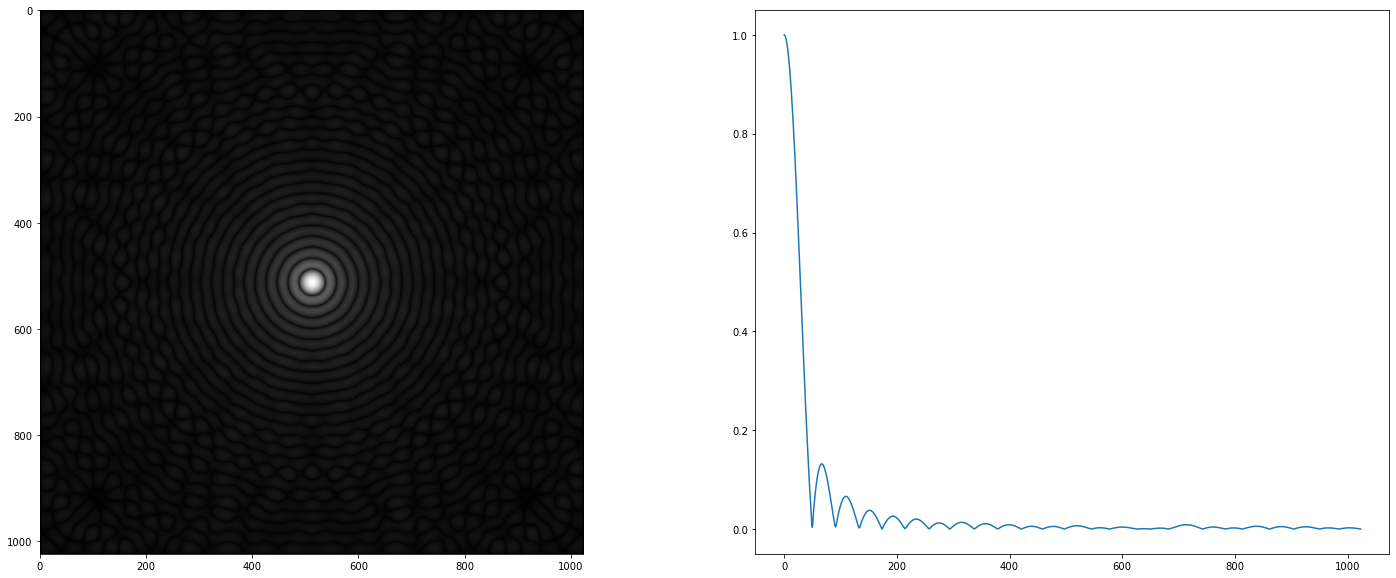

5225.435942912155


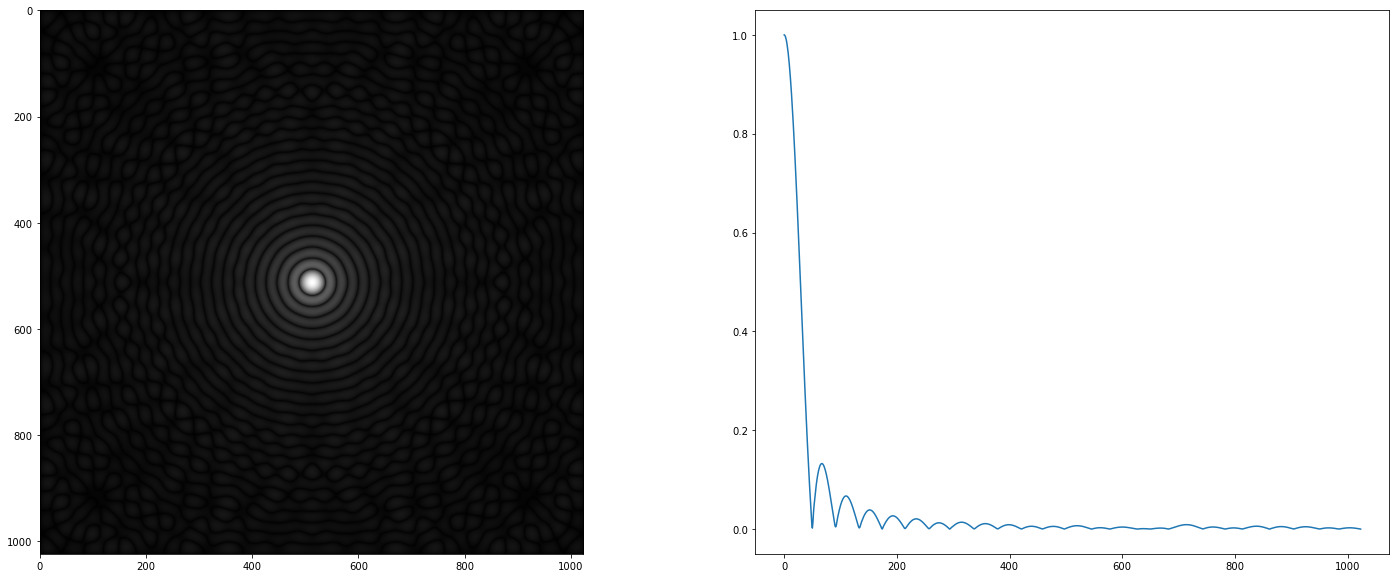

In [3]:
setscope(100,0, True)
#setaperture(20,-20,10,10)
dx=0
startest(f"D{str(dx).zfill(2)}_",0,0, False, False, True)
setscope(100,0, False)
#setaperture(20,-20,10,10)
d=startest(f"D{str(dx).zfill(2)}_",0,0, False, False, True)


18604.238724776194


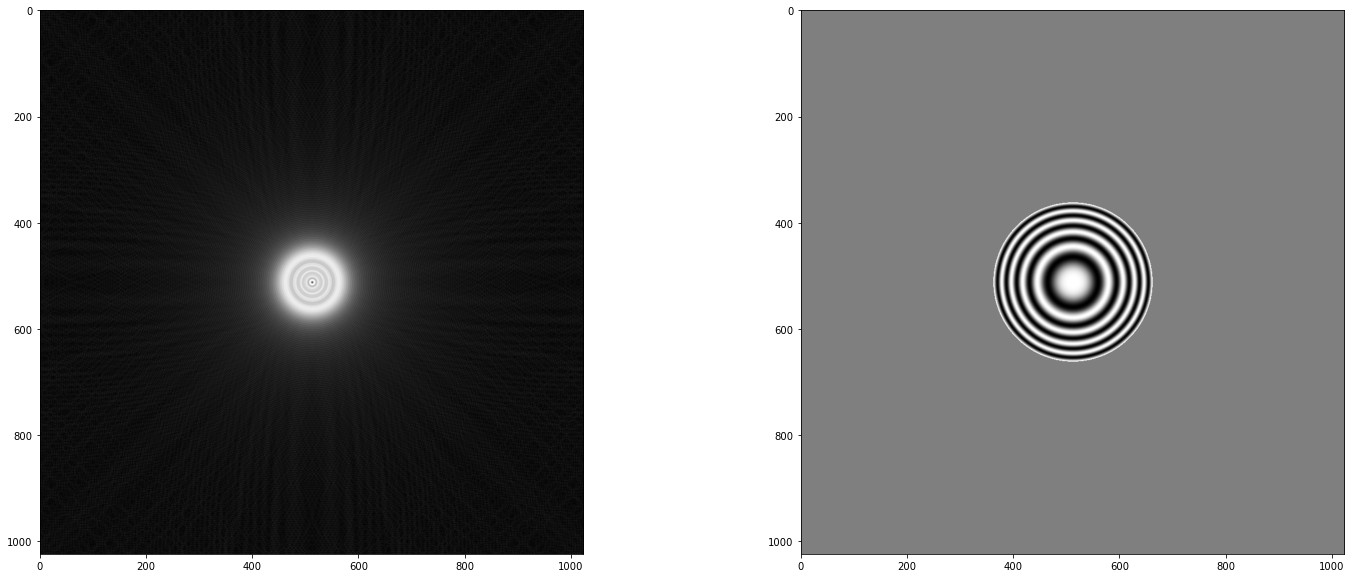

18604.238724776194


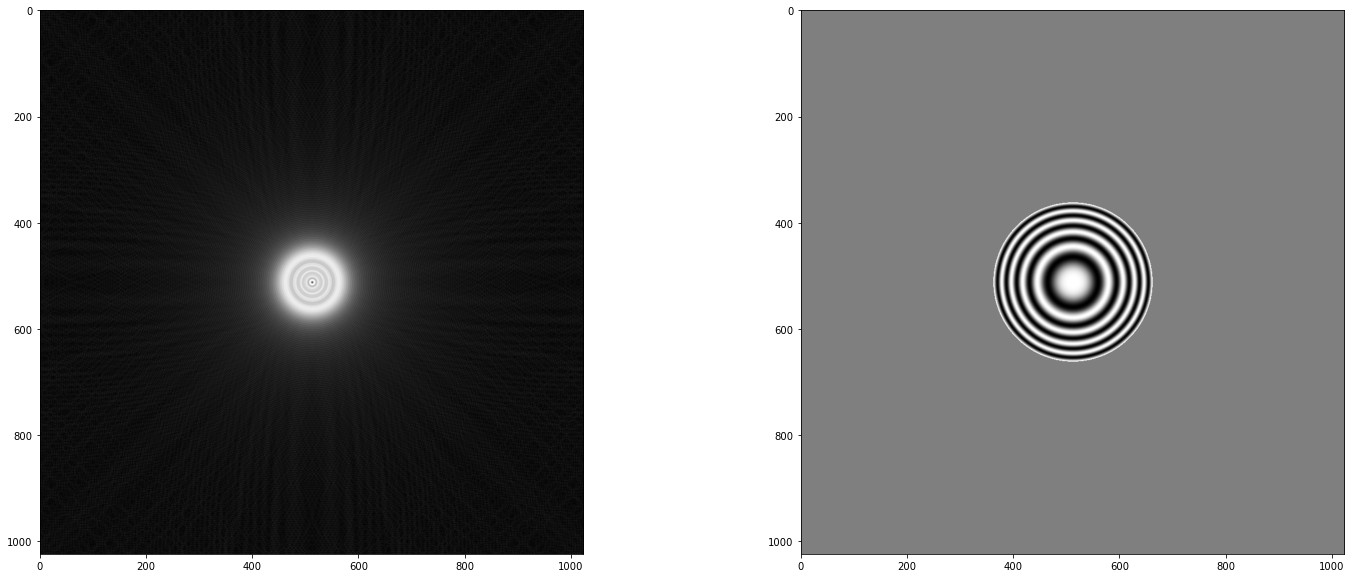

In [5]:
#moving apertures from inside to outside - circular to slit
def setaperture(xleft,xright,rad1,rad2):
      global k
      aperture_l=distmat(r,[512,512+xleft]) 
      aperture_r=distmat(r,[512,512+xright])
      #aperture_up=distmat(r,[512+xleft,512])
      k1=k*(aperture_l<rad1)
      k2=k*(aperture_r<rad2)
      #k3=k*(aperture_up<radius)
      k=k1+k2
    
for dx in range(2):
    setscope(600,0,False)
    #setaperture(70+dx*2.5,-70-dx*2.5,40,60)
    startest(f"D{str(dx).zfill(2)}_",5,0, True, False,False)

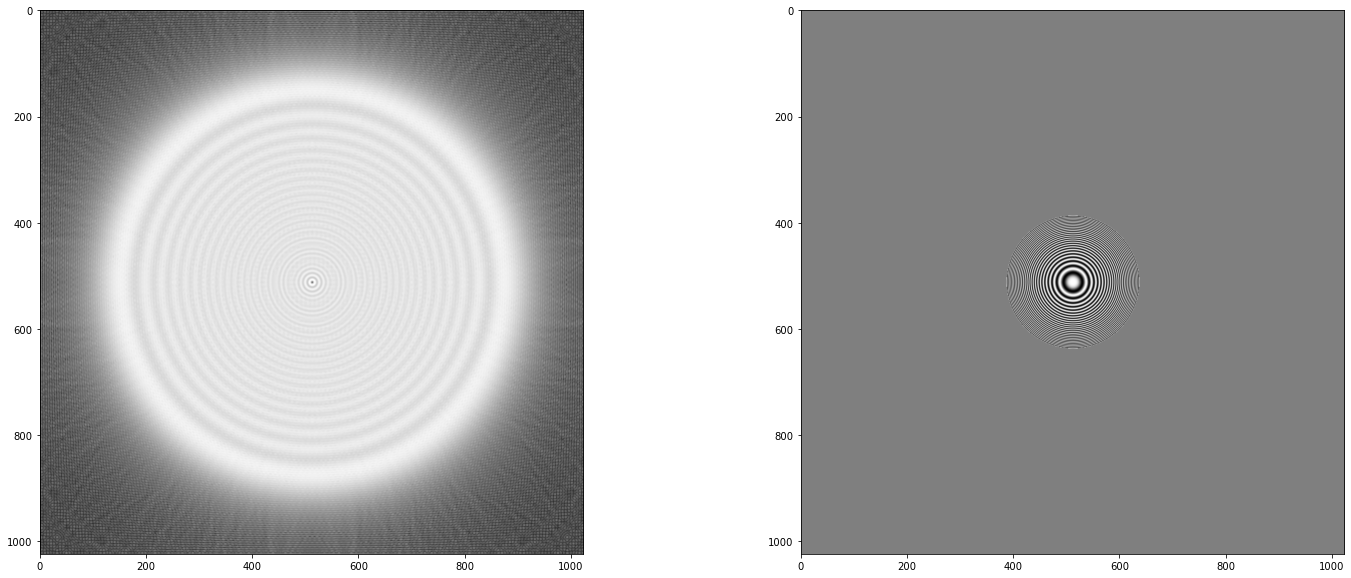

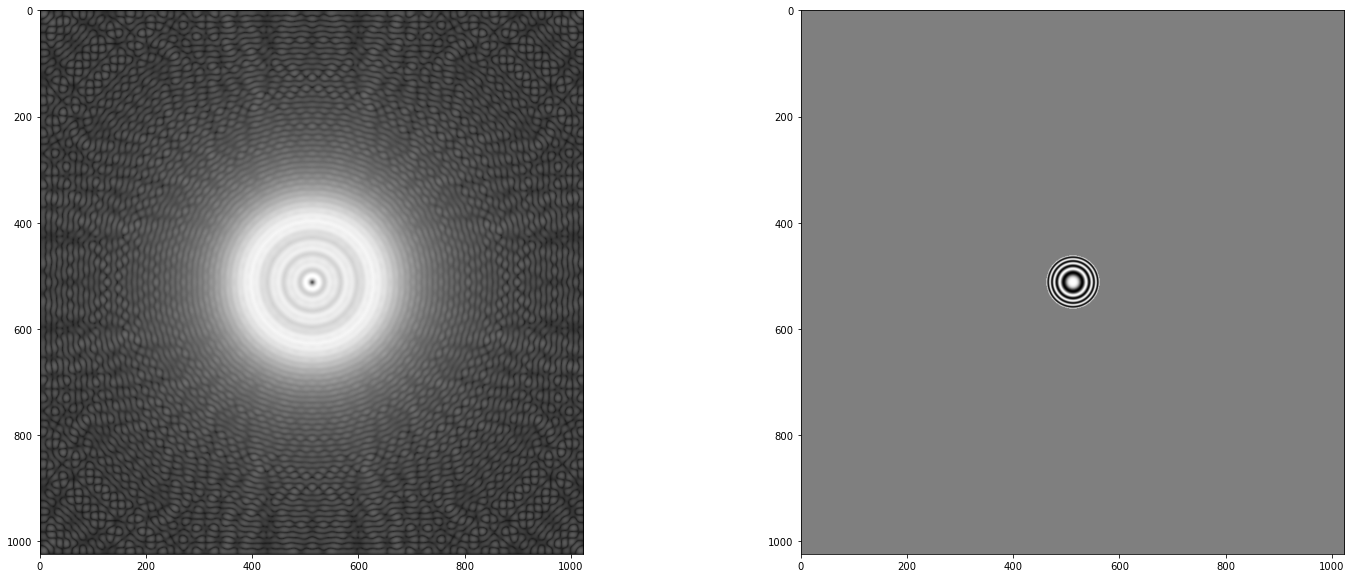

In [278]:
def setaperture(xleft,xright,rad1,rad2):
      global k
      k[:,:]=False
      cx=512
      cy=512
      h=20
      l=200
      k[cx-2:cx+2,cx-2:cx+3]=True
      k[cx-h:cx+h,cx+h:cx+h+l]=True  #rightside
      k[cx-h-l//2:cx+h+l//2,cx-h-l//2:cx+h-l//2]=True  #rightside
        
    #k[470:550,455:475]=True
    
setscope(200,0, True)
#setaperture(20,-20,10,10)
startest(f"D{str(dx).zfill(2)}_",4,0, True, False)
setscope(200,0, False)
#setaperture(20,-20,10,10)
startest(f"D{str(dx).zfill(2)}_",4,0, True, False)

rms 3.93 1/0.3
PV: lo 0.0 hi 15.102
strehl estimate -608.6883376789359
minima [1.756 2.634 3.805]
peak0.017 sq: 0.0
EE 1stmin 0.001
EE 2ndmin 0.001


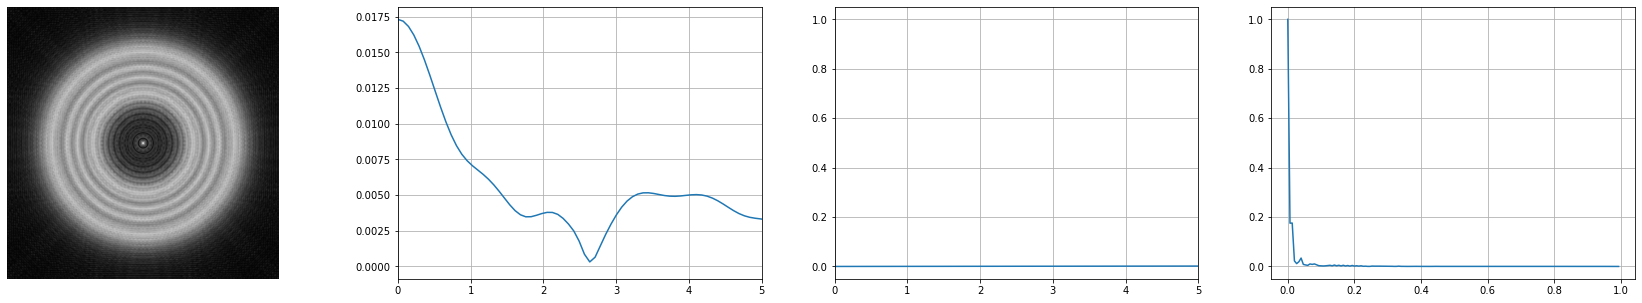

rms 3.956 1/0.3
PV: lo -14.89 hi 0.0
strehl estimate -616.9016193598152
minima [1.683 2.634 4.757]
peak0.02 sq: 0.0
EE 1stmin 0.001
EE 2ndmin 0.001


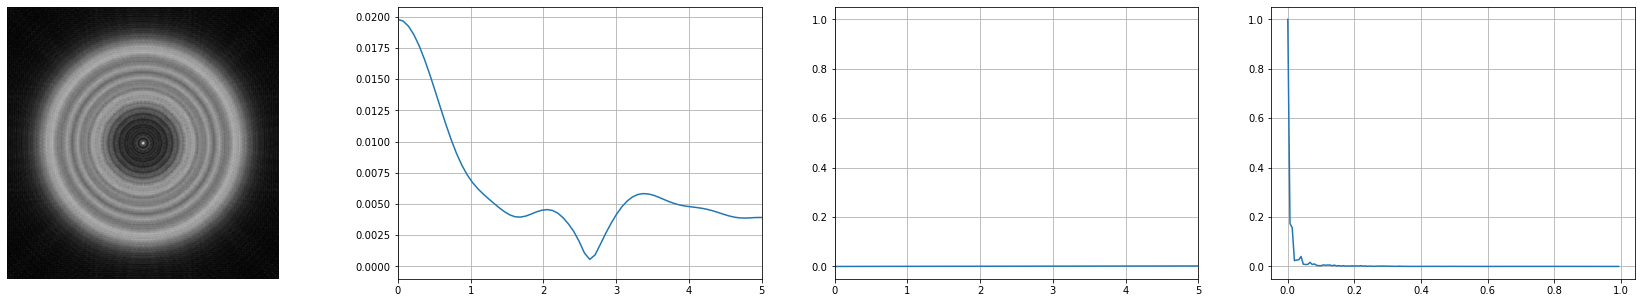

In [619]:
import numpy as np
import scipy.ndimage
from scipy.signal import argrelextrema
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

twopi=np.pi*2

#setup calculation matrix
gridN=1024      
gridspace=1024j    
x,y=np.mgrid[-1:1:gridspace,-1:1:gridspace]
r=(x*x +y*y)

def radial_profile2(data, center):
    data=data*data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radialsum=np.cumsum(tbin) 
    radialsum=radialsum/radialsum.max()
    return radialprofile,radialsum 

def mtf(data, center):
    data=data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radialprofile=radialprofile/radialprofile.max()
    return radialprofile


def startest(objectief,obstruction,focus,lsa,hsa, showgraph):
    obstruct=obstruction
    
    airy1st=50*100/objectief*gridN/1024
    firstmin=3.8317/np.pi # 3.8317 is the 1st minimum of the Besselfunction J1 https://en.wikipedia.org/wiki/Airy_disk
    airy1st=airy1st/firstmin #calculate the floatingpoint position-index of the 1st minimum

    radius=objectief/(gridN*2)
    radius=radius*radius #we have squared distance to center in matrix r
    k=(r<=radius) #mask outside the radius to False 
    
    #maxintensity based on aperture and active cells in matrix 
    maxintens=k.sum()
    
    r2=r/radius #create squared radius field within radius only 
    r4=r2*r2 # and power4 radius too 
    
    #create LSA and HSA fields
    lsafield=4*(r2-r4+1/6)
    hsafield=-0.51*(20*r4*r2-30*r4+12*r2-1)
    
    #create obstruction as percentage of radius
    obstruction=objectief/(gridN*2)*obstruction/100
    l=(r>=(obstruction*obstruction)) #create mask for obstruction
    
    pupil=k*l #create pupil from aperture and obstruction
    
    #build wavefront 
    aberration=r2*focus
    
    if lsa!=0:
        aberration+= lsa*lsafield
    
    if hsa!=0:
        aberration+= hsa*hsafield
        
    aberration=twopi*aberration
    
    ficount=(k.sum()-(gridN*gridN-l.sum())) #cells in simulation
    wave=aberration*pupil #only use cells in pupil
    fisum=wave.sum()/ficount #calculate average aberration
    fisum=wave-fisum #subtract average to leave deviation
    fisum=fisum*pupil# again restrict to pupil
    fisum=np.square(fisum) #square the deviations
    rmssum=fisum.sum() #sum the deviations
    rmssum=rmssum/ficount #average
    rmssum=np.sqrt(rmssum)/twopi #square-root
    if rmssum>0:
      print(f"rms {rmssum.round(3)} 1/{(1/rmssum).round(1)}")
    else:
      print("rms=0, perfect wavefront at focus")  
    print(f"PV: lo {(wave.min()/twopi).round(3)} hi {(wave.max()/twopi).round(3)}")
    print(f"strehl estimate {(1-(twopi*rmssum)**2)}")
    
    #calculate both real and imaginary part of the wavefront
    real=np.cos(aberration)
    imag=np.sin(aberration)

    #create wavefront restricted by mask for radius and obstruction (otherwise zero)
    wavefront=(real+1j*imag)*pupil 
      
    #calculate fft on the wavefront
    dft=np.fft.fft2(wavefront)
    
    #psf=dft* np.conjugate(dft)
    #mft=abs(np.fft.fft2(psf))
    
    
    #rearrange quads from dft to form airy-disk 
    data=np.fft.fftshift(abs(dft))
    
    
    data=data/maxintens
    useMTF=True
    if useMTF:
      MTF = abs(np.fft.fftshift(np.fft.fft2(data*data)));
    
    #intensity goes down based on obstruction
#     o=obstruct/100
#     o=o*o
#     data=data*(1-o)**2
 
    if showgraph:
        num = gridN//2
        x1, y1 = 0, num # These are in _pixel_ coordinates!!
        x0, y0 = num, num
        x, y = np.linspace(x0, x1, num*2), np.linspace(y0, y1, num*2)
        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(data, np.vstack((x,y)))
        mins=argrelextrema(zi, np.less)
        minset=mins[0]/airy1st
        
        print('minima',minset[:3].round(3))
        print(f'peak{data.max().round(3)} sq: {(data.max()**2).round(3)}')
        
        fig, ax = plt.subplots(ncols=4,figsize=(30,5))
        p,q=radial_profile2(data,[511,511])
        
        print(f'EE 1stmin {q[mins[0][0]//2].round(3)}')   
        print(f'EE 2ndmin {q[mins[0][1]//2].round(3)}')   
        x1=((x.max()-x)*2)/airy1st
        
        ax[0].imshow(data,cmap='gray')
        ax[0].axis('off')
       
        ax[1].plot(x1,zi)
        ax[1].grid(True)
        ax[1].set_xlim((0,5))
        
        x1=x1*2
        if x1.shape[0]>q.shape[0]:
           ax[2].plot(x1[:q.shape[0]],q)
        else:
           ax[2].plot(x1,q[:x1.shape[0]]) 
        ax[2].set_xlim((0,5))
        ax[2].grid(True)
        
        q=mtf(MTF,[512,512])
        x2=np.arange(0,objectief//2)
        x2=x2/(objectief/2)
        ax[3].plot(x2,q[:objectief//2])
        ax[3].grid(True)   
        plt.show()
        plt.close()
        fig.clf()
    return data

objectief=300
obstruction=30
focus=15
lsa=0.09
hsa=-0.09
data=startest(objectief,30, focus,lsa,hsa,True)
data=startest(objectief,30, -focus,lsa,hsa,True)

print()
